# SD6101 Data Science Thinking Team 7 Project

<h3 class="alert alert-block alert-warning">Task 1 - Data Preprocessing

In [153]:
import pandas as pd
import numpy as np
import re
import math

# change this path accordingly
filepath = 'C:/Users/mrq_q/Downloads/amazon_sales_dataset/amazon.csv'

# load data and remove duplicate reviews 
df = pd.read_csv(filepath)
df = df.drop_duplicates(subset=['review_id'])

# split category into 'main' and 'sub'
df[['main_category','subcategory']] = df['category'].str.split('|').apply(lambda x: pd.Series([x[0],x[-1]]))

# convert prices to float, remove currency and thousand separator
df['discounted_price_rp'] = df['discounted_price'].str[1:].str.replace(',','').astype(float)
df['actual_price_rp'] = df['actual_price'].str[1:].str.replace(',','').astype(float)
    
# convert discount percentage to decimal
df['discount_percent_decimal'] = df['discount_percentage'].str[:-1].astype(int) / 100

# convert rating and replace | with NaN
df['rating'] = df['rating'].replace('|',np.nan).astype(float)

# clean review - lowercase, keep only text, spaces, and punctuation
df['review_title'] = df['review_title'].str.lower().str.replace(r'[^a-z0-9\s!.,?;\'"-]', '', regex=True)
df['review_content'] = df['review_content'].str.lower().str.replace(r'[^a-z0-9\s!.,?;\'"-]', '', regex=True)

# remove thousand separators in rating_count, convert to integer
df['rating_count'] = df['rating_count'].str.replace(',','')

# remove rows with missing ratings\n",
df = df.dropna(subset=['rating','rating_count'])
df['rating_count'] = df['rating_count'].astype(int)

# remove rating outliers (rating lower than 1 & higher than 5)
df = df[(df['rating'] >= 1) & (df['rating'] <= 5)]

# remove discount percentage outliers (less than 0 and greater than 1)
df = df[(df['discount_percent_decimal'] >= 0) & (df['discount_percent_decimal'] <= 100)]

# filter low rating counts (not consider rating counts less than 10)
df = df[df['rating_count'] >= 10]

# take the mean between max and min rating to classify rating into high and low
high_threshold = df['rating'].max() - (df['rating'].max() - df['rating'].min()) / 2

# high_low_rating
df['high_low_rating'] = df['rating'].apply(lambda x: 'High' if x >= high_threshold else 'Low')

# extract only the columns needed for analysis
column_order = ["product_id", "product_name", "main_category", "subcategory","rating", "high_low_rating","rating_count", "actual_price_rp", "discounted_price_rp", "discount_percent_decimal", "user_id","user_name","review_id","review_title", "review_content"]
df = df[column_order]

# summary of data frame after preprocessing\n",
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1180 entries, 0 to 1464
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   product_id                1180 non-null   object 
 1   product_name              1180 non-null   object 
 2   main_category             1180 non-null   object 
 3   subcategory               1180 non-null   object 
 4   rating                    1180 non-null   float64
 5   high_low_rating           1180 non-null   object 
 6   rating_count              1180 non-null   int32  
 7   actual_price_rp           1180 non-null   float64
 8   discounted_price_rp       1180 non-null   float64
 9   discount_percent_decimal  1180 non-null   float64
 10  user_id                   1180 non-null   object 
 11  user_name                 1180 non-null   object 
 12  review_id                 1180 non-null   object 
 13  review_title              1180 non-null   object 
 14  review_conten

In [155]:
# first 5 entries in data frame
df.head()

,product_id,product_name,main_category,subcategory,rating,high_low_rating,rating_count,actual_price_rp,discounted_price_rp,discount_percent_decimal,user_id,user_name,review_id,review_title,review_content
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,USBCables,4.2,High,24269,1099.0,399.0,0.64,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","satisfied,charging is really fast,value for mo...",looks durable charging is fine toono complains...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories,USBCables,4.0,High,43994,349.0,199.0,0.43,"AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","a good braided cable for your type c device,go...",i ordered this cable to connect my phone to an...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories,USBCables,3.9,High,7928,1899.0,199.0,0.90,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","good speed for earlier versions,good product,w...","not quite durable and sturdy,httpsm.media-amaz..."
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories,USBCables,4.2,High,94363,699.0,329.0,0.53,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","good product,good one,nice,really nice product...","good product,long wire,charges good,nice,i bou..."
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories,USBCables,4.2,High,16905,399.0,154.0,0.61,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","as good as original,decent,good one for second...","bought this instead of original apple, does th..."


In [157]:
# last 5 entries in data frame
df.tail()

,product_id,product_name,main_category,subcategory,rating,high_low_rating,rating_count,actual_price_rp,discounted_price_rp,discount_percent_decimal,user_id,user_name,review_id,review_title,review_content
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen,WaterPurifierAccessories,4.0,High,1090,919.0,379.0,0.59,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...","Prabha ds,Raghuram bk,Real Deal,Amazon Custome...","R3G3XFHPBFF0E8,R3C0BZCD32EIGW,R2EBVBCN9QPD9R,R...","received the product without spanner,excellent...","i received product without spanner,excellent p..."
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen,Rice&PastaCookers,4.1,High,4118,3045.0,2280.0,0.25,"AFG5FM3NEMOL6BNFRV2NK5FNJCHQ,AGEINTRN6Z563RMLH...","Manu Bhai,Naveenpittu,Evatira Sangma,JAGANNADH...","R3DDL2UPKQ2CK9,R2SYYU1OATVIU5,R1VM993161IYRW,R...","ok,everything was good couldn't return bcoz i ...","ok,got everything as mentioned but the measuri..."
1462,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,Home&Kitchen,HeatConvectors,3.6,Low,468,3080.0,2219.0,0.28,"AGVPWCMAHYQWJOQKMUJN4DW3KM5Q,AF4Q3E66MY4SR7YQZ...","Nehal Desai,Danish Parwez,Amazon Customer,Amaz...","R1TLRJVW4STY5I,R2O455KRN493R1,R3Q5MVGBRIAS2G,R...","very good,work but front melt after 2 month,go...","plastic but cool body ,u have to find sturdy s..."
1463,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,Home&Kitchen,ExhaustFans,4.0,High,8031,1890.0,1399.0,0.26,"AF2JQCLSCY3QJATWUNNHUSVUPNQQ,AFDMLUXC5LS5RXDJS...","Shubham Dubey,E.GURUBARAN,Mayank S.,eusuf khan...","R39Q2Y79MM9SWK,R3079BG1NIH6MB,R29A31ZELTZNJM,R...","fan speed is slow,good quality,good product,go...",i have installed this in my kitchen working fi...
1464,B01486F4G6,Borosil Jumbo 1000-Watt Grill Sandwich Maker (...,Home&Kitchen,SandwichMakers,4.3,High,6987,3690.0,2863.0,0.22,"AFGW5PT3R6ZAVQR4Y5MWVAKBZAYA,AG7QNJ2SCS5VS5VYY...","Rajib,Ajay B,Vikas Kahol,PARDEEP,Anindya Prama...","R20RBRZ0WEUJT9,ROKIFK9R2ISSE,R30EEG2FNJSN5I,R2...","works perfect,ok good product,nice product. re...",it does it job perfectly..only issue is temp c...


<h3 class="alert alert-block alert-warning">Task 2 - Hypotheses Testing</h3>

<h4><code style="background:green;color:white">GLM - Rating</code> </h4>

In [169]:
#temp_df for analysis
temp_df = df.copy()

#Filter Rating
temp_df = df[(df['rating'] >= 3.5) & (df['rating'] <= 4.6)]

#Retain only 3 main categories
temp_df = df[df['main_category'].isin(['Home&Kitchen', 'Electronics', 'Computers&Accessories'])]
temp_df['main_category'] = pd.Categorical(temp_df['main_category'], categories=['Home&Kitchen', 'Electronics', 'Computers&Accessories'])

#Binning
bins = [-1, 0.33, 0.66, 1]
labels = ['Low', 'Medium', 'High']  # Define labels for each bin
temp_df['discount_level'] = pd.cut(temp_df['discount_percent_decimal'], bins=bins, labels=labels, right=False)
ori_temp = temp_df.copy()

temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1142 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   product_id                1142 non-null   object  
 1   product_name              1142 non-null   object  
 2   main_category             1142 non-null   category
 3   subcategory               1142 non-null   object  
 4   rating                    1142 non-null   float64 
 5   high_low_rating           1142 non-null   object  
 6   rating_count              1142 non-null   int32   
 7   actual_price_rp           1142 non-null   float64 
 8   discounted_price_rp       1142 non-null   float64 
 9   discount_percent_decimal  1142 non-null   float64 
 10  user_id                   1142 non-null   object  
 11  user_name                 1142 non-null   object  
 12  review_id                 1142 non-null   object  
 13  review_title              1142 non-null   object  
 1

C:\Users\mrq_q\AppData\Local\Temp\ipykernel_39084\682036654.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['main_category'] = pd.Categorical(temp_df['main_category'], categories=['Home&Kitchen', 'Electronics', 'Computers&Accessories'])
C:\Users\mrq_q\AppData\Local\Temp\ipykernel_39084\682036654.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['discount_level'] = pd.cut(temp_df['discount_percent_decimal'], bins=bins, labels=labels, right=False)


In [171]:
temp_df.head()

,product_id,product_name,main_category,subcategory,rating,high_low_rating,rating_count,actual_price_rp,discounted_price_rp,discount_percent_decimal,user_id,user_name,review_id,review_title,review_content,discount_level
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories,USBCables,4.2,High,24269,1099.0,399.0,0.64,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","satisfied,charging is really fast,value for mo...",looks durable charging is fine toono complains...,Medium
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories,USBCables,4.0,High,43994,349.0,199.0,0.43,"AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","a good braided cable for your type c device,go...",i ordered this cable to connect my phone to an...,Medium
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories,USBCables,3.9,High,7928,1899.0,199.0,0.90,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","good speed for earlier versions,good product,w...","not quite durable and sturdy,httpsm.media-amaz...",High
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories,USBCables,4.2,High,94363,699.0,329.0,0.53,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","good product,good one,nice,really nice product...","good product,long wire,charges good,nice,i bou...",Medium
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories,USBCables,4.2,High,16905,399.0,154.0,0.61,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","as good as original,decent,good one for second...","bought this instead of original apple, does th...",Medium


In [173]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Build the formula for GLM with interaction
formula = 'rating ~ main_category * discount_percent_decimal'
gamma_model = smf.glm(formula=formula, data=temp_df, family=sm.families.Gaussian()).fit()

# Display
print(gamma_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 rating   No. Observations:                 1142
Model:                            GLM   Df Residuals:                     1136
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                        0.083685
Method:                          IRLS   Log-Likelihood:                -200.94
Date:                Sun, 17 Nov 2024   Deviance:                       95.066
Time:                        21:03:32   Pearson chi2:                     95.1
No. Iterations:                     3   Pseudo R-squ. (CS):            0.06147
Covariance Type:            nonrobust                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

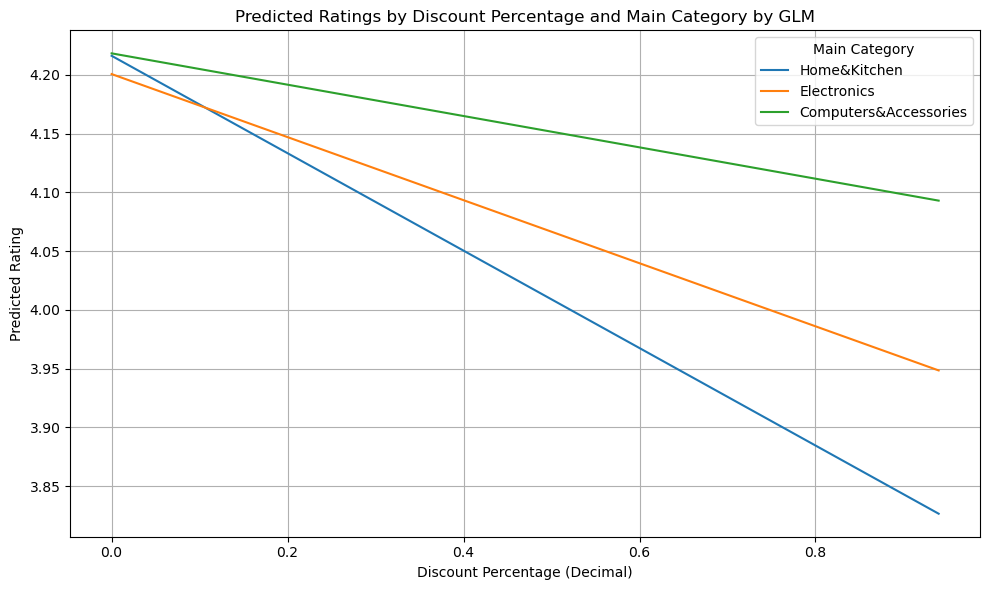

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define categories and generate a range of discount percentages
categories = ['Home&Kitchen', 'Electronics', 'Computers&Accessories']
discount_range = np.linspace(temp_df['discount_percent_decimal'].min(), temp_df['discount_percent_decimal'].max(), 100)

# Dictionary to store predictions for each category
predictions = {}

for category in categories:
    # Create a DataFrame for predictions, with discount values and current category
    pred_df = pd.DataFrame({
        'discount_percent_decimal': discount_range,
        'main_category': pd.Categorical([category] * len(discount_range), categories=categories)
    })
    # Predict ratings using the GLM model for each discount percentage and category
    predictions[category] = gamma_model.predict(pred_df)

# Plot the predictions
plt.figure(figsize=(10, 6))
for category, pred in predictions.items():
    plt.plot(discount_range, pred, label=f"{category}")

plt.title("Predicted Ratings by Discount Percentage and Main Category by GLM")
plt.xlabel("Discount Percentage (Decimal)")
plt.ylabel("Predicted Rating")
plt.legend(title="Main Category")
plt.grid(True)
plt.tight_layout()
plt.show()

<h4><code style="background:green;color:white">GLM - Total Sales</code> </h4>

In [177]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

temp_df = df[df['main_category'].isin(['Home&Kitchen', 'Electronics', 'Computers&Accessories'])]
temp_df['main_category'] = pd.Categorical(temp_df['main_category'], categories=['Home&Kitchen', 'Electronics', 'Computers&Accessories'])

# Build the formula for GLM with interaction
formula = 'rating_count ~ main_category * discount_percent_decimal'
gamma_model = smf.glm(formula=formula, data=temp_df, family=sm.families.Gaussian()).fit()

# Display
print(gamma_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           rating_count   No. Observations:                 1142
Model:                            GLM   Df Residuals:                     1136
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                      1.0954e+09
Method:                          IRLS   Log-Likelihood:                -13502.
Date:                Sun, 17 Nov 2024   Deviance:                   1.2444e+12
Time:                        21:03:36   Pearson chi2:                 1.24e+12
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04458
Covariance Type:            nonrobust                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

C:\Users\mrq_q\AppData\Local\Temp\ipykernel_39084\3097043320.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['main_category'] = pd.Categorical(temp_df['main_category'], categories=['Home&Kitchen', 'Electronics', 'Computers&Accessories'])


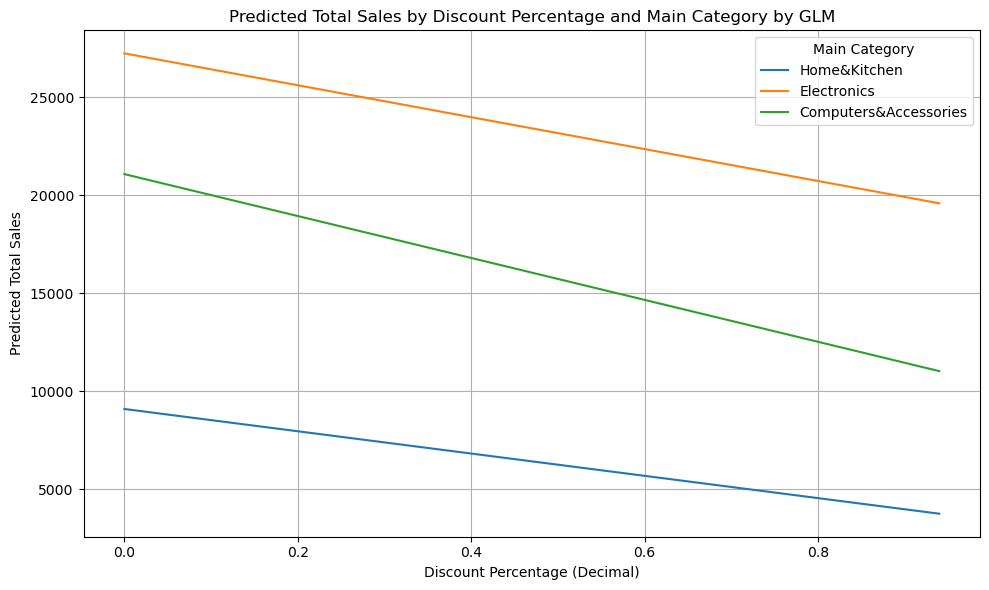

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define categories
categories = ['Home&Kitchen', 'Electronics', 'Computers&Accessories']

discount_range = np.linspace(temp_df['discount_percent_decimal'].min(), temp_df['discount_percent_decimal'].max(), 100)

predictions = {}
for category in categories:
    # create temp df for pred
    pred_df = pd.DataFrame({
        'discount_percent_decimal': discount_range,
        'main_category': pd.Categorical([category] * len(discount_range), categories=categories)
    })
    # Predict
    predictions[category] = gamma_model.predict(pred_df)

# Plot
plt.figure(figsize=(10, 6))
for category, pred in predictions.items():
    plt.plot(discount_range, pred, label=f"{category}")

plt.title("Predicted Total Sales by Discount Percentage and Main Category by GLM")
plt.xlabel("Discount Percentage (Decimal)")
plt.ylabel("Predicted Total Sales")
plt.legend(title="Main Category")
plt.grid(True)
plt.tight_layout()
plt.show()

<h4><code style="background:green;color:white">Two-Way ANOVA</code> </h4>

In [183]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# two-way anova on rating
model = smf.ols('rating ~ C(discount_level) + C(main_category) + C(discount_level):C(main_category)', data=ori_temp).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Display
print(anova_table)

                                       sum_sq      df          F        PR(>F)
C(discount_level)                    2.785398     2.0  16.496598  8.668638e-08
C(main_category)                     2.722821     2.0  16.125984  1.242802e-07
C(discount_level):C(main_category)   0.631735     4.0   1.870733  1.132667e-01
Residual                            95.651714  1133.0        NaN           NaN


In [185]:
# two-way anova on sales
model = smf.ols('rating_count ~ C(discount_level) + C(main_category) + C(discount_level):C(main_category)', data=ori_temp).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Display
print(anova_table)

                                          sum_sq      df          F  \
C(discount_level)                   4.085717e+09     2.0   1.876807   
C(main_category)                    5.499049e+10     2.0  25.260330   
C(discount_level):C(main_category)  1.019527e+10     4.0   2.341640   
Residual                            1.233242e+12  1133.0        NaN   

                                          PR(>F)  
C(discount_level)                   1.535537e-01  
C(main_category)                    1.849817e-11  
C(discount_level):C(main_category)  5.322224e-02  
Residual                                     NaN  


<h4 class="alert alert-block alert-success">Visualisation - Top 10 Main & Subcategories by Average Ratings</h4>

Average Ratings by Main Category:
 main_category
OfficeProducts           4.309677
Toys&Games               4.300000
HomeImprovement          4.250000
Computers&Accessories    4.149375
Electronics              4.060938
Home&Kitchen             4.050457
Health&PersonalCare      4.000000
MusicalInstruments       3.900000
Car&Motorbike            3.800000
Name: rating, dtype: float64

Average Ratings by Subcategory:
 subcategory
Tablets              4.6
CoffeePresses        4.5
SurgeProtectors      4.5
PaintingMaterials    4.5
Film                 4.5
                    ... 
InkjetPrinters       3.6
PCHeadsets           3.5
3DGlasses            3.5
DustCovers           3.4
ElectricGrinders     3.3
Name: rating, Length: 206, dtype: float64


C:\Users\mrq_q\AppData\Local\Temp\ipykernel_39084\2289100803.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_main_categories.values, y=top_main_categories.index, palette="viridis")


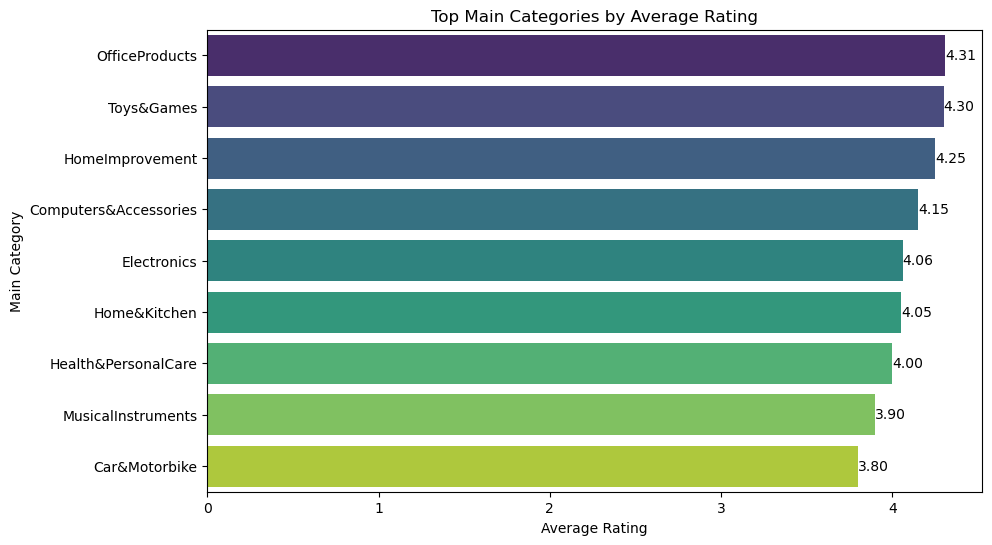

C:\Users\mrq_q\AppData\Local\Temp\ipykernel_39084\2289100803.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_subcategories.values, y=top_subcategories.index, palette="magma")


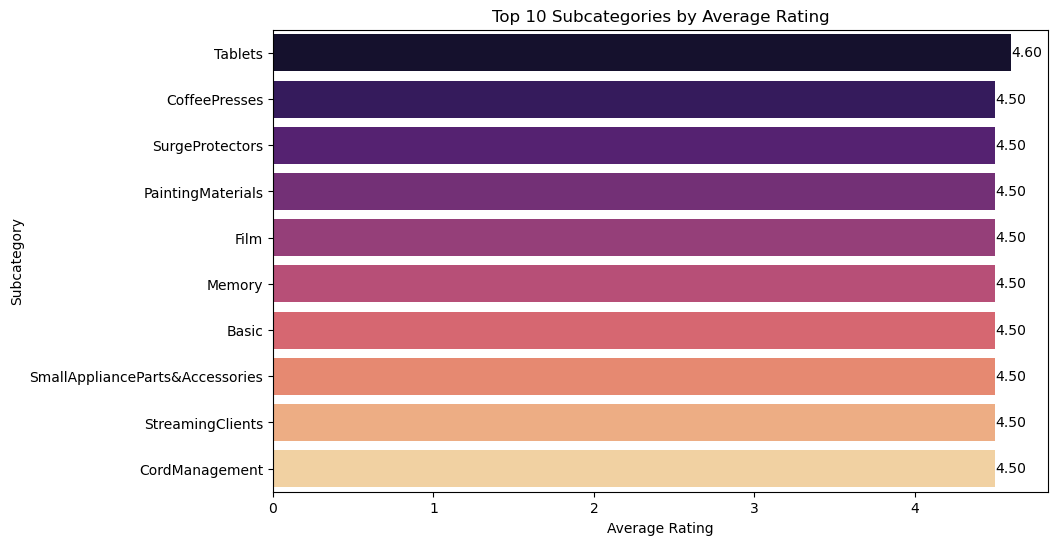

In [187]:
# calculate and sort average ratings by main category
main_category_avg_ratings = df.groupby('main_category')['rating'].mean().sort_values(ascending=False)
print("Average Ratings by Main Category:\n", main_category_avg_ratings)

# calculate and sort average ratings by subcategory
subcategory_avg_ratings = df.groupby('subcategory')['rating'].mean().sort_values(ascending=False)
print("\nAverage Ratings by Subcategory:\n", subcategory_avg_ratings)

# top 10 main categories by average ratings
top_main_categories = main_category_avg_ratings

# plot for main categories
plt.figure(figsize=(10, 6))
sns.barplot(x=top_main_categories.values, y=top_main_categories.index, palette="viridis")
plt.xlabel('Average Rating')
plt.ylabel('Main Category')
plt.title('Top Main Categories by Average Rating')

for i, value in enumerate(top_main_categories.values):
    plt.text(value, i, f'{value:.2f}', va='center')

plt.show()

# top 10 subcategories by average ratings
top_subcategories = subcategory_avg_ratings.head(10)

# plot for subcategories
plt.figure(figsize=(10, 6))
sns.barplot(x=top_subcategories.values, y=top_subcategories.index, palette="magma")
plt.xlabel('Average Rating')
plt.ylabel('Subcategory')
plt.title('Top 10 Subcategories by Average Rating')

for i, value in enumerate(top_subcategories.values):
    plt.text(value, i, f'{value:.2f}', va='center')
    
plt.show()

<h3 class="alert alert-block alert-warning">Task 3 - Implementation on Dataset (Sentiment Analysis)</h3>

<h4 class="alert alert-block alert-success">Sentiment Analysis - Approach 1: Pure Lexicon-Based</h4>

In [189]:
import pandas as pd
import emoji
import nltk
from langdetect import detect
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import string
import re
import joblib

# download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

def preprocess_data(df):
    
    # emoji conversion
    df['review'] = df['review'].apply(lambda text: emoji.demojize(text, delimiters=(" ", " "))).str.lower()
    df['review'] = df['review'].str.lower()

    # handle contractions and punctuation
    df['review'] = df['review'].str.replace(r"\b(\w+)'s\b", r"\1", regex=True)
    df['review'] = df['review'].str.replace(r"\b(\w+)'d\b", r"\1", regex=True)
    df['review'] = df['review'].str.replace(r"\b(can't)\b", "can't", regex=True)
    df['review'] = df['review'].str.replace(r"n't\b", " not", regex=True)
    df['review'] = df['review'].str.replace(f"[{string.punctuation}]", "", regex=True)

    # sentiment score
    analyzer = SentimentIntensityAnalyzer()
    df['review_sentiment'] = df['review'].apply(lambda review: analyzer.polarity_scores(review)['compound'])
    
    return df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mrq_q\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [191]:
amazon_df = df

# split the relevant columns by commas
amazon_df['user_id'] = amazon_df['user_id'].str.split(',')
amazon_df['user_name'] = amazon_df['user_name'].str.split(',').apply(lambda x: [name.upper() for name in x])
amazon_df['review_id'] = amazon_df['review_id'].str.split(',')

# apply the transformations to each element in the review columns
amazon_df['review_title'] = amazon_df['review_title'].str.split(',').apply(
    lambda x: [item for item in x]
)
amazon_df['review_content'] = amazon_df['review_content'].str.split(',').apply(
    lambda x: [item for item in x]
)

# reset the index to avoid reindexing issues
amazon_df = amazon_df.reset_index(drop=True)

# get the maximum length of the 'review_id' column
max_len = amazon_df['review_id'].apply(len).max()

# create an empty list to store processed rows
processed_rows = []

# iterate over each row in the DataFrame
for _, row in amazon_df.iterrows():
    # get the length of the review_id list for the current row
    max_len = len(row['review_id'])
    
    # ensure all columns have the same length as review_id by truncating the lists
    review_id = row['review_id'][:max_len]
    user_id = row['user_id'][:max_len]
    user_name = row['user_name'][:max_len]
    review_title = row['review_title'][:max_len]
    review_content = row['review_content'][:max_len]
    
    # create a new DataFrame from the current row's exploded and truncated lists
    exploded_row = pd.DataFrame({
        'review_id': review_id,
        'user_id': user_id,
        'user_name': user_name,
        'review_title': review_title,
        'review_content': review_content,
        'main_category': row['main_category'],
        'subcategory': row['subcategory'],
        'product_id': row['product_id'],
        'product_name': row['product_name'],
        'rating_count': row['rating_count']
    })
    
    # append the processed row to the list
    processed_rows.append(exploded_row)

# concatenate all the processed rows into a final DataFrame
review_df = pd.concat(processed_rows, ignore_index=True)

# drop duplicates if needed
review_df = review_df.drop_duplicates(subset='review_id', keep='first')
review_df = review_df.dropna(subset=['review_id'])

# reset the index of the final review DataFrame
review_df = review_df.reset_index(drop=True)

review_df['review'] = review_df['review_title'] + " " + review_df['review_content']

# replacing empty string with np.NaN
review_df['review'] = review_df['review'].replace(' ', np.nan)

# remove rows with missing ratings\n",
review_df = review_df.dropna(subset=['rating_count','review'])
review_df['rating_count'] = review_df['rating_count'].astype(int)

review_df = preprocess_data(review_df)

In [192]:
# individual review separated from list
review_df.head()

,review_id,user_id,user_name,review_title,review_content,main_category,subcategory,product_id,product_name,rating_count,review,review_sentiment
0,R3HXWT0LRP0NMF,AG3D6O4STAQKAY2UVGEUV46KN35Q,MANAV,satisfied,looks durable charging is fine toono complains,Computers&Accessories,USBCables,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,24269,satisfied looks durable charging is fine toono...,0.2500
1,R2AJM3LFTLZHFO,AHMY5CWJMMK5BJRBBSNLYT3ONILA,ADARSH GUPTA,charging is really fast,charging is really fast,Computers&Accessories,USBCables,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,24269,charging is really fast charging is really fast,0.0000
2,R6AQJGUP6P86,AHCTC6ULH4XB6YHDY6PCH2R772LQ,SUNDEEP,value for money,good product.,Computers&Accessories,USBCables,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,24269,value for money good product,0.6486
3,R1KD19VHEDV0OR,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,S.SAYEED AHMED,product review,till now satisfied with the quality.,Computers&Accessories,USBCables,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,24269,product review till now satisfied with the qua...,0.4215
4,R3C02RMYQMK6FC,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,JASPREET SINGH,good quality,this is a good product . the charging speed is...,Computers&Accessories,USBCables,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,24269,good quality this is a good product the charg...,0.7964


<h4><code style="background:green;color:white">Lexicon Approach's output purely based on the sentiment scores</code> </h4>

In [195]:
# classify based on compound score
review_df['lexicon_output'] = review_df['review_sentiment'].apply(lambda x: 'Positive' if x > 0.1 else ('Negative' if x < -0.1 else 'Neutral'))

# display sentiment label counts
print(review_df['lexicon_output'].value_counts())

# check the first few rows to confirm the results
print(review_df[['review', 'review_sentiment', 'lexicon_output']].head())

lexicon_output
Positive    7320
Negative     954
Neutral      941
Name: count, dtype: int64
                                              review  review_sentiment  \
0  satisfied looks durable charging is fine toono...            0.2500   
1    charging is really fast charging is really fast            0.0000   
2                      value for money  good product            0.6486   
3  product review till now satisfied with the qua...            0.4215   
4  good quality this is a good product  the charg...            0.7964   

  lexicon_output  
0       Positive  
1        Neutral  
2       Positive  
3       Positive  
4       Positive  


<h4 class="alert alert-block alert-success">Sentiment Analysis - Approach 2: Lexicon + ML</h4>

In [197]:
shopee_path = "C:/Users/mrq_q/Downloads/shopee.csv"
shopee_df = pd.read_csv(shopee_path)

# preprocess data
cleaned_df = preprocess_data(shopee_df)

In [198]:
def filter_outliers(df):
    # filter rows where sentiment score doesn't match the 3-class rating
    def is_outlier(row):
        if row['rating'] < 3 and row['review_sentiment'] > 0.1:  # positive sentiment but negative class
            return True
        elif row['rating'] == 3 and (row['review_sentiment'] < -0.1 or row['review_sentiment'] > 0.1):  # neutral rating but strong sentiment
            return True
        elif row['rating'] > 3 and row['review_sentiment'] < -0.1:  # negative sentiment but positive class
            return True
        return False
    
    return df[~df.apply(is_outlier, axis=1)]  # remove rows that match the outlier condition

# filter outliers based on sentiment mismatch
sp_df = filter_outliers(cleaned_df)

# show the distribution of classes before balancing
print("Class distribution before balancing:")
print(sp_df['rating'].value_counts())

Class distribution before balancing:
rating
4    40808
5    40478
1    11756
2     7250
3     6390
Name: count, dtype: int64


In [199]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import numpy as np

def balance_data(df, rating_column):
    # define target sample size for each class
    negative_samples = 18900  # For strongly negative ratings
    neutral_samples = 6390   # For neutral ratings
    positive_samples = 81000  # For strongly positive ratings

    # resample each class accordingly
    balanced_neg_df = df[df[rating_column].isin([1, 2])].sample(n=negative_samples, replace=True, random_state=42)
    balanced_neutral_df = df[df[rating_column] == 3].sample(n=neutral_samples, replace=True, random_state=42)
    balanced_pos_df = df[df[rating_column].isin([4, 5])].sample(n=positive_samples, replace=True, random_state=42)

    # combine all resampled dataframes
    balanced_df = pd.concat([balanced_neg_df, balanced_neutral_df, balanced_pos_df])

    # show the distribution of classes after balancing
    print("Class distribution after balancing:")
    print(balanced_df[rating_column].value_counts())
    
    return balanced_df

def transform_rating(rating):
    if rating in [1, 2]:
        return 'Negative'  # strongly negative
    elif rating == 3:
        return 'Neutral'  # neutral
    elif rating in [4, 5]:
        return 'Positive'  # strongly positive
        
# function to reshape sentiment to 2D
def reshape_sentiment(x):
    return np.array(x).reshape(-1, 1)

def train_and_predict_ratings(df):

    # show the distribution of classes before balancing
    print("Class distribution before balancing:")
    print(df['rating'].value_counts())

    # ask for confirmation before proceeding
    confirm = input("Proceed with balancing and further processing? (yes/no): ").strip().lower()
    if confirm != 'yes':
        print("Process aborted by the user.")
        return None

    # balance the dataset
    df = balance_data(df, 'rating')

    # transform ratings from 1-5 to 0-1 scale
    df['high_low_rating'] = df['rating'].apply(transform_rating)

    # define features and target variable
    X = df[['review','review_sentiment']]
    y = df['high_low_rating']  # target variable on 0-2 scale

    # train/test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    # pipeline with TF-IDF Vectorization and SVM Classifier
    pipeline = Pipeline([
       ('features', ColumnTransformer([
            ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 3), max_features=5000), 'review'),
            ('sentiment', FunctionTransformer(reshape_sentiment), 'review_sentiment') # Reshape sentiment to 2D 
        ])),
        ('svm', SVC(C=1, gamma='scale', kernel='rbf', random_state=42))
    ])

    # train the SVM Model
    pipeline.fit(X_train, y_train)

    # make predictions
    y_pred = pipeline.predict(X_test)

    # evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # save the trained pipeline to a file
    joblib.dump(pipeline, "sentiment_model.pkl")
    return pipeline  # return the trained model pipeline
    
model = train_and_predict_ratings(sp_df)

Class distribution before balancing:
rating
4    40808
5    40478
1    11756
2     7250
3     6390
Name: count, dtype: int64


Proceed with balancing and further processing? (yes/no):  yes


Class distribution after balancing:
rating
4    40902
5    40098
1    11651
2     7249
3     6390
Name: count, dtype: int64
Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.91      0.89      3807
     Neutral       0.72      0.43      0.54      1287
    Positive       0.96      0.98      0.97     16164

    accuracy                           0.94     21258
   macro avg       0.85      0.77      0.80     21258
weighted avg       0.93      0.94      0.93     21258



<h4><code style="background:green;color:white">Comparison between Lexicon and ML approach</code> </h4>

In [201]:
# load the trained pipeline model
pipeline = joblib.load("sentiment_model.pkl")

# function to predict ratings on a new dataset
def predict_new_data(new_data_df, text_column, sentiment_column):
    # ensure the new data contains the required text column
    X_new = new_data_df[[text_column,sentiment_column]]
    
    # predict ratings using the loaded pipeline
    new_data_df['ml_output'] = pipeline.predict(X_new)
    
    return new_data_df  # return the DataFrame with predictions

review_df = predict_new_data(review_df, text_column='review',sentiment_column='review_sentiment')

# display lexicon output counts
print(review_df['ml_output'].value_counts())

# check the first few rows to compare results between lexicon and ml approach
print(review_df[['review', 'review_sentiment', 'lexicon_output', 'ml_output']].head())

ml_output
Positive    7608
Negative    1473
Neutral      134
Name: count, dtype: int64
                                              review  review_sentiment  \
0  satisfied looks durable charging is fine toono...            0.2500   
1    charging is really fast charging is really fast            0.0000   
2                      value for money  good product            0.6486   
3  product review till now satisfied with the qua...            0.4215   
4  good quality this is a good product  the charg...            0.7964   

  lexicon_output ml_output  
0       Positive  Positive  
1        Neutral  Positive  
2       Positive  Positive  
3       Positive  Positive  
4       Positive  Positive  


<h3 class="alert alert-block alert-warning">Task 4 - Recommendation System

<h4><code style="background:green;color:white">Case 1 - Item Based Recommendation System on Main and Sub Category</code> </h4>

In [204]:
from sklearn.metrics.pairwise import cosine_similarity

# create a combined category string for each product
df['category_combined'] = df['main_category'] + ' ' + df['subcategory']

# apply TF-IDF to the combined category column
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['category_combined'])

# compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# create a function to get recommendations based on main_category and subcategory
def get_recommendations_by_category(product_id, cosine_sim=cosine_sim):
    # get the index of the product that matches the product_id
    idx = df[df['product_id'] == product_id].index[0]
    
    # get similarity scores for all products with the given product
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort products based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # get the indices of the top 5 most similar products, excluding itself (the first one)
    sim_scores = sim_scores[1:6]  # Exclude the first one which is the product itself
    product_indices = [i[0] for i in sim_scores]
    
    # create a DataFrame for the recommendations with similarity scores
    recommendations = df.iloc[product_indices][['product_id', 'product_name', 'main_category', 'subcategory']]
    recommendations['similarity_score'] = [score for _, score in sim_scores]  # Add similarity scores
    
    # return the recommendations with similarity scores
    return recommendations

# example: get recommendations for a product with product_id 'B07KCMR8D6'
recommendations_cat = get_recommendations_by_category('B07KCMR8D6')

# get the product details for the given product_id
product_details = df[df['product_id'] == 'B07KCMR8D6'][['product_name', 'main_category', 'subcategory']]

# display the product details
product_name = product_details['product_name'].values[0]
main_category = product_details['main_category'].values[0]
subcategory = product_details['subcategory'].values[0]

# display the product name, main category, and subcategory
print(f"Product Name: {product_name}")
print(f"Main Category: {main_category}")
print(f"Subcategory: {subcategory}")
print("\nRecommended Products:")
print(recommendations_cat)

Product Name: Classmate Octane Neon- Blue Gel Pens(Pack of 5)|Smooth Writing Pen|Attractive body colour for Boys & Girls|Waterproof ink for smudge free writing|Preferred by Students for Exam|Study at home essential
Main Category: OfficeProducts
Subcategory: GelInkRollerballPens

Recommended Products:
     product_id                                       product_name  \
858  B00LOD70SC  Pilot V7 Liquid Ink Roller Ball Pen (2 Blue + ...   
761  B00LHZWD0C  Luxor 5 Subject Single Ruled Notebook - A4, 70...   
778  B00LHZW3XY  Luxor 5 Subject Single Ruled Notebook - A5 Siz...   
790  B00J4YG0PC  Classmate Long Notebook - 140 Pages, Single Li...   
811  B00P93X2H6  Classmate Pulse Spiral Notebook - 240 mm x 180...   

      main_category               subcategory  similarity_score  
858  OfficeProducts  RetractableBallpointPens          1.000000  
761  OfficeProducts      CompositionNotebooks          0.335952  
778  OfficeProducts      CompositionNotebooks          0.335952  
790  OfficePr

<h4><code style="background:green;color:white">Case 2 - Item Based Recommendation System on Product Name</code> </h4>

In [206]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# apply TF-IDF to the 'product_name' column
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['product_name'])

# compute the cosine similarity matrix between products
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# create a function to recommend products based on product_name
def get_recommendations_by_name(product_id, cosine_sim=cosine_sim):
    # get the index of the product that matches the product_id
    idx = df[df['product_id'] == product_id].index[0]
    
    # get similarity scores for all products with the given product
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # sort products based on similarity scores (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # get the indices of the top 5 most similar products
    sim_scores = sim_scores[1:6]  # Exclude itself (the first one)
    product_indices = [i[0] for i in sim_scores]
    
    # extract the similarity scores and the corresponding products
    recommended_products = df.iloc[product_indices][['product_id', 'product_name', 'main_category', 'subcategory']]
    
    # add similarity scores to the recommendations
    recommended_products['similarity_score'] = [score for _, score in sim_scores]
    
    return recommended_products

# example: get recommendations for a product with product_id 'B07KCMR8D6'
recommendations_name = get_recommendations_by_name('B07KCMR8D6')

# get the product details for the given product_id
product_details = df[df['product_id'] == 'B07KCMR8D6'][['product_name', 'main_category', 'subcategory']]

# display the product details
product_name = product_details['product_name'].values[0]
main_category = product_details['main_category'].values[0]
subcategory = product_details['subcategory'].values[0]

# display the product name, main category, and subcategory
print(f"Product Name: {product_name}")
print(f"Main Category: {main_category}")
print(f"Subcategory: {subcategory}")

# display the recommended products with similarity scores
print("\nRecommended Products with Similarity Scores:")
print(recommendations_name)


Product Name: Classmate Octane Neon- Blue Gel Pens(Pack of 5)|Smooth Writing Pen|Attractive body colour for Boys & Girls|Waterproof ink for smudge free writing|Preferred by Students for Exam|Study at home essential
Main Category: OfficeProducts
Subcategory: GelInkRollerballPens

Recommended Products with Similarity Scores:
      product_id                                       product_name  \
993   B00S2SEV7K  Pilot Frixion Clicker Roller Pen (Blue), (9000...   
955   B0746N6WML  Parker Vector Camouflage Gift Set - Roller Bal...   
919   B00LZPQVMK  Parker Vector Standard Chrome Trim Ball Pen (I...   
1004  B07LFQLKFZ  Parker Moments Vector Timecheck Gold Trim Roll...   
850   B07SBGFDX9     Pentonic Multicolor Ball Point Pen, Pack of 10   

       main_category              subcategory  similarity_score  
993   OfficeProducts  LiquidInkRollerballPens          0.415295  
955   OfficeProducts       StickBallpointPens          0.308855  
919   OfficeProducts       StickBallpointPens     

<h4><code style="background:green;color:white">Case 3 - User Based Recommendation System on Subcategory</code> </h4>

In [208]:
from collections import defaultdict
from scipy.sparse import csr_matrix

# flatten the list of user IDs and remove leading/trailing whitespace
unique_users = review_df['user_id'].unique()

# get unique subcategories
unique_product = review_df['product_id'].unique()

# create mappings for rows and columns
user_to_index = {user: idx for idx, user in enumerate(unique_users)}
product_to_index = {product_id: idx for idx, product_id in enumerate(unique_product)}

# initialize review_counts dictionary with default values as tuples (count, some_other_value)
review_counts = defaultdict(lambda: (0, 0))  # (count, some_other_value)

# loop through the rows in the DataFrame
for idx, row in review_df.iterrows():
    if pd.notna(row['user_id']) and pd.notna(row['product_id']):
        product_id = row['product_id']
        user = row['user_id'] 
        current_count, user_total_rating = review_counts[(user.strip(), product_id)]
        if row['ml_output'] == 'Negative':
            score = 1 # Negative to 1
        elif row['ml_output'] == 'Neutral':
            score = 2 # Neutral to 2
        else:
            score = 3 # Positive to 3
        review_counts[(user.strip(), product_id)] = (current_count + 1, user_total_rating + score)

# populate row indices, column indices, and data with totalrating / count
row_ind, col_ind, data = [], [], []
for (user, product), (count,totalrating) in review_counts.items():
    row_ind.append(user_to_index[user])                    # map user_id to index
    col_ind.append(product_to_index[product])      # map subcategory to index

    # calculate totalrating / count (avoid division by zero)
    if count > 0:
        data.append(totalrating / count)  # append average rating (totalrating / count)
    else:
        data.append(0)  # if count is zero, avoid division by zero

# create sparse matrix with shape based on unique users and subcategories
sparse_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(len(unique_users), len(unique_product)))

# convert sparse matrix to DataFrame for inspection
sparse_df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, index=unique_users, columns=unique_product)

# create the product master DataFrame with the relevant columns
product_master = review_df[['product_id', 'product_name', 'subcategory', 'main_category', 'rating_count']].drop_duplicates(subset=['product_id'])

In [209]:
# enter User ID to show recommendation
user_id = 'AGPSJBF6CTEE4MJG3X5Z3DMJEJZA'
user_name = review_df[review_df['user_id'] == user_id]['user_name'].unique()[0]

user_row = sparse_df.loc[user_id]

# filter out zero values
non_zero_columns = user_row[user_row != 0]

# reset the index of non_zero_columns to convert it to a DataFrame
non_zero_df = non_zero_columns.reset_index()
non_zero_df.columns = ['product_id', 'rating']  # Rename columns for clarity

# merge non_zero_df with product_master on 'product_id' to retrieve the product names
result = non_zero_df.merge(product_master[['product_id', 'product_name']], on='product_id', how='left')

# display the top recommendations with mean_rating >= 3
print(f"\n== Rated Products by User {user_id} ({user_name}) ==")
# display the resulting DataFrame with product names and ratings
print(result)

# get all non-zero rated products for the user
user_ratings = sparse_df.loc[user_id]
rated_products = user_ratings[user_ratings > 0].index

# initialize a list to store recommended products and their comparison scores
recommendations = []

for product_id in rated_products:
    user_rating = user_ratings[product_id]  # Get the user's rating for this product
    
    # fetch main category and subcategory of the product from product_master
    product_info = product_master[product_master['product_id'] == product_id].iloc[0]
    main_cat, sub_cat = product_info['main_category'], product_info['subcategory']
    
    # find products in the same subcategory (including the rated product itself)
    same_cat_products = product_master[(product_master['main_category'] == main_cat) &
                                       (product_master['subcategory'] == sub_cat)]
    
    # calculate the mean rating for each product in the category
    for other_product_id in same_cat_products['product_id']:
        product_ratings = sparse_df[other_product_id]
        mean_rating = product_ratings[product_ratings > 0].mean()  # Mean of non-zero ratings
        
        # calculate the difference between this mean rating and the user's rating
        score = abs(mean_rating - user_rating)
        
        # append the product and score to the recommendations list
        recommendations.append((other_product_id, mean_rating))

# sort recommendations by score (highest difference first) and select the top 10
recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:10]

# fetch product names for the top recommendations
top_recommendations = pd.DataFrame(recommendations, columns=['product_id', 'mean_rating'])
top_recommendations = top_recommendations.merge(product_master[['product_id', 'product_name','rating_count','subcategory']], on='product_id')

# sort by mean_rating first, then rating_count in descending order
top_recommendations = top_recommendations.sort_values(by=['mean_rating', 'rating_count'], ascending=[False, False])

# filter products with mean_rating >= 3
top_recommendations_filtered = top_recommendations[top_recommendations['mean_rating'] >= 2]

# display the top recommendations with mean_rating >= 3
print(f"\n== Top Product Recommendations for User {user_id} ({user_name}) with mean_rating >= 2 ==")
print(top_recommendations_filtered[['product_id', 'product_name', 'rating_count', 'subcategory', 'mean_rating']])



== Rated Products by User AGPSJBF6CTEE4MJG3X5Z3DMJEJZA (VIPUL VORA) ==
   product_id  rating                                       product_name
0  B08ZHYNTM1     3.0  Havells Festiva 1200mm Dust Resistant Ceiling ...
1  B097MKZHNV     3.0  Racold Pronto Pro 3Litres 3KW Vertical Instant...

== Top Product Recommendations for User AGPSJBF6CTEE4MJG3X5Z3DMJEJZA (VIPUL VORA) with mean_rating >= 2 ==
   product_id                                       product_name  \
7  B0BR4F878Q  Swiffer Instant Electric Water Heater Faucet T...   
2  B095PWLLY6  Crompton Hill Briz Deco 1200mm (48 inch) High ...   
6  B078JDNZJ8  Havells Instanio 3-Litre Instant Geyser (White...   
0  B07SPVMSC6            Bajaj Frore 1200 mm Ceiling Fan (Brown)   
1  B09SPTNG58  Crompton Sea Sapphira 1200 mm Ultra High Speed...   
4  B08ZHYNTM1  Havells Festiva 1200mm Dust Resistant Ceiling ...   
3  B07ZJND9B9  ACTIVA 1200 MM HIGH SPEED 390 RPM BEE APPROVED...   
5  B01L7C4IU2  Havells Ambrose 1200mm Ceiling Fan (Pearl 

<h3 class="alert alert-block alert-warning">Word Clouds for Negative and Positive Reviews

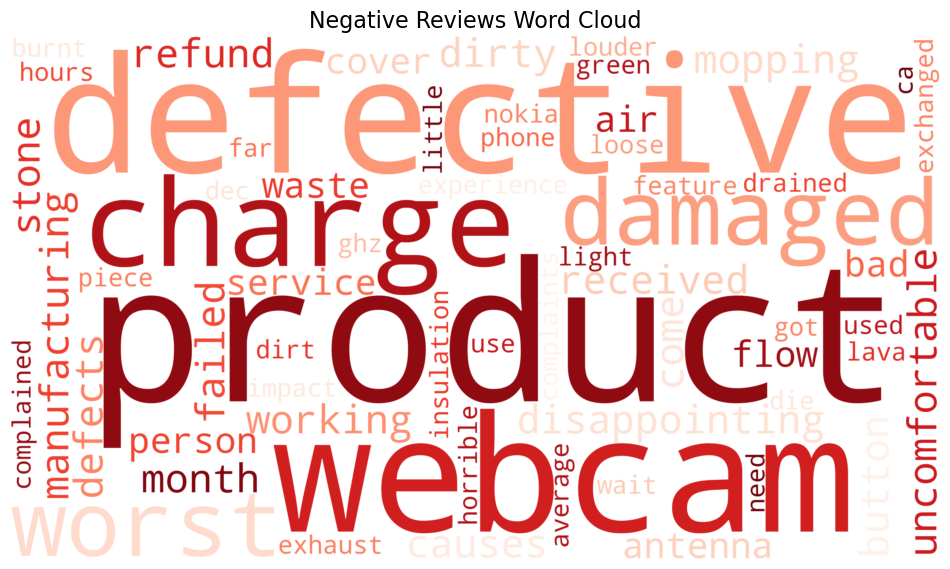

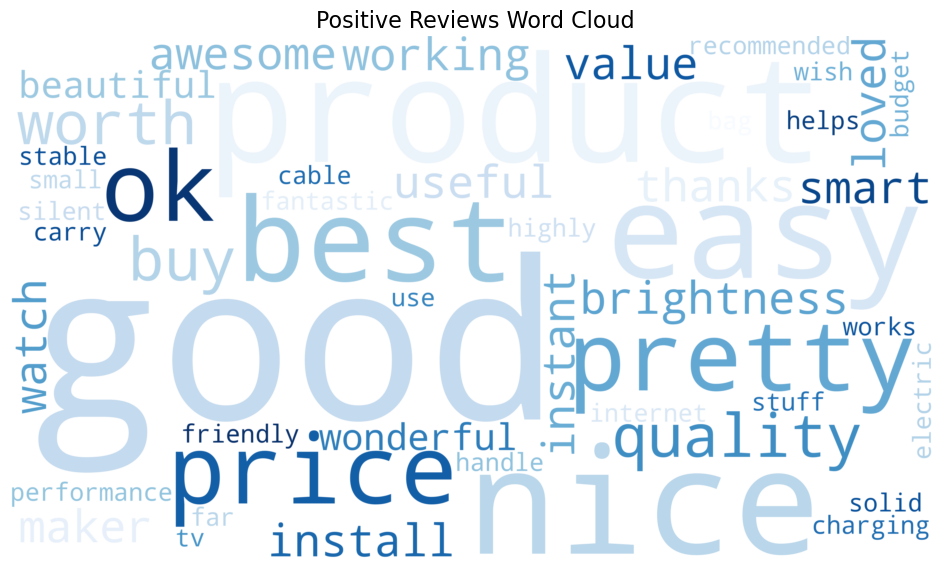

In [213]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Separate the reviews based on predicted ratings
negative_reviews = review_df[review_df['ml_output'] == 'Negative']['review']
positive_reviews = review_df[review_df['ml_output'] == 'Positive']['review']

# Initialize CountVectorizer for word frequency calculation
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)

# Fit and transform the negative reviews for word frequency
X_neg = vectorizer.fit_transform(negative_reviews)
neg_word_counts = X_neg.sum(axis=0).A1  # Sum all word counts for each word
neg_terms = vectorizer.get_feature_names_out()
neg_word_freq = dict(zip(neg_terms, neg_word_counts))

# Fit and transform the positive reviews for word frequency
X_pos = vectorizer.fit_transform(positive_reviews)
pos_word_counts = X_pos.sum(axis=0).A1
pos_terms = vectorizer.get_feature_names_out()
pos_word_freq = dict(zip(pos_terms, pos_word_counts))

# Get the words that appear in both categories (intersection)
common_words = set(neg_word_freq.keys()).intersection(set(pos_word_freq.keys()))

# Remove common words from both negative and positive word frequencies
neg_word_freq_filtered = {word: count for word, count in neg_word_freq.items() if word not in common_words}
pos_word_freq_filtered = {word: count for word, count in pos_word_freq.items() if word not in common_words}

# Sort the words by frequency in descending order for negative and positive reviews
sorted_neg_words = sorted(neg_word_freq_filtered.items(), key=lambda x: x[1], reverse=True)
sorted_pos_words = sorted(pos_word_freq_filtered.items(), key=lambda x: x[1], reverse=True)

# Create a string for the word cloud using the top words based on frequency
top_neg_words = ' '.join([word for word, count in sorted_neg_words[:50]])
top_pos_words = ' '.join([word for word, count in sorted_pos_words[:50]])

# Generate word cloud for negative reviews with red color scheme
negative_wordcloud = WordCloud(width=3840, height=2160, background_color='white', colormap='Reds').generate(top_neg_words)

# Generate word cloud for positive reviews with blue color scheme
positive_wordcloud = WordCloud(width=3840, height=2160, background_color='white', colormap='Blues').generate(top_pos_words)

# Display the negative word cloud
plt.figure(figsize=(12, 8))  # Adjust the figure size
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title("Negative Reviews Word Cloud", fontsize=16)  # Add a title
plt.show()  # Show the plot

# Display the positive word cloud
plt.figure(figsize=(12, 8))  # Adjust the figure size
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title("Positive Reviews Word Cloud", fontsize=16)  # Add a title
plt.show()  # Show the plot